In [1]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
import scipy as sc 
import os

from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_predict

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools
from copy import deepcopy

# don't forget to upload utils file to the colab session
from utils import qualityMAPE, qualityRMSE
import warnings

  - level --- attitude  of a time series ar a moment $t$ (usually is equal to original value) 
  - trend - speed of incremental increase/descrease of level compnent
  - seasonality - cyclic component of a time series
  - noise (errors) - random component of a time series
  

In [2]:
data = pd.read_csv(r'C:/Users/George/Desktop/Magistratyra/Project/Concantinate/result.csv', index_col='Unnamed: 0')

<AxesSubplot: xlabel='Timestamp'>

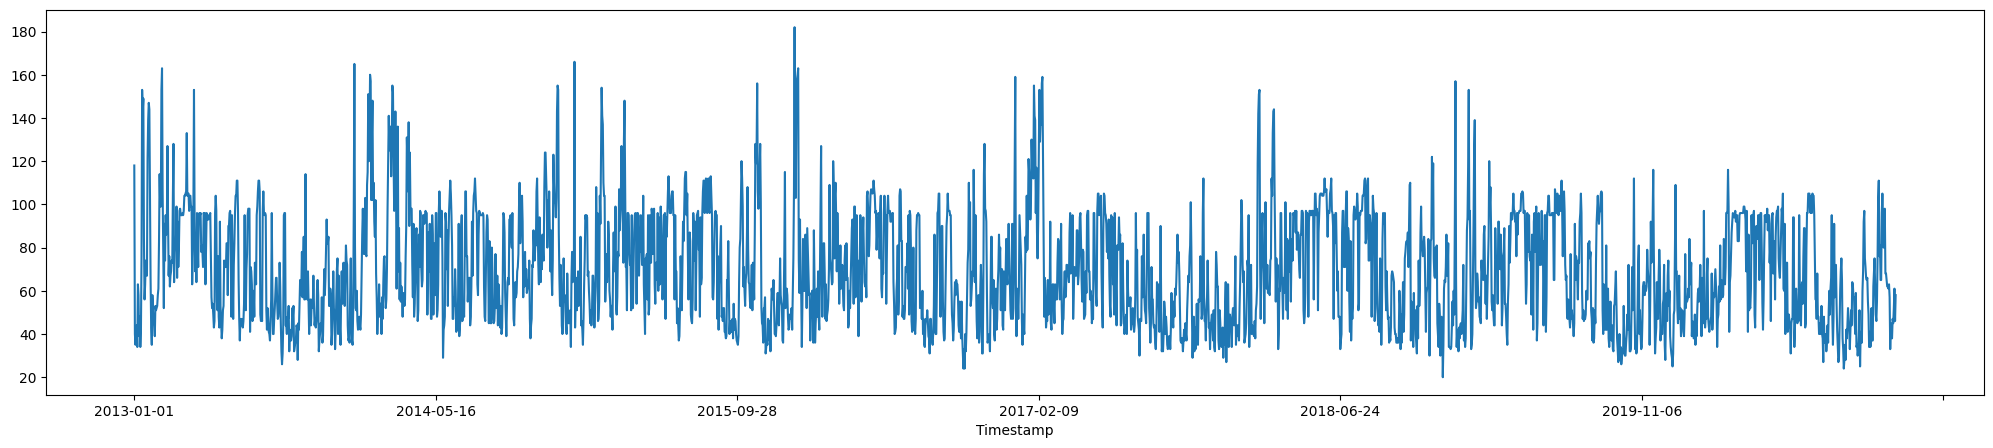

In [3]:
ts_wage = pd.read_csv(r'C:/Users/George/Desktop/Magistratyra/Project/Concantinate/result.csv', index_col='Unnamed: 0')
ts_wage.index.names=['Timestamp']
ts_wage = ts_wage['AQI'].sort_index() # sort index
ts_wage.plot(figsize = (25,5))

# По графику заметно наличие сезонной компоненты и отсутствие тренда.

In [4]:
def get_autoregrmatrix(x,h,K):
    T = len(x)
    X = sc.linalg.hankel(x[:T-h-K+1], 
                          np.hstack((x[T-h-K:T-h]))) # is needed to repeat x[-K] in second part
    y = x[K+h-1:]
    return X,y

In [5]:
K= 300
h = 1 # delay (горизонn прогнозирования)

x_train = data['AQI']['2013-01-01':'2018-01-01']
x_test =  data['AQI']['2018-01-02':'2020-12-31']

X_train, y_train = get_autoregrmatrix(x_train,h,K)
X_test, y_test = get_autoregrmatrix(x_test,h,K)

In [6]:
len(x_train)

1827

In [7]:
len(x_test)

1095

Train score: 0.604, Test score: 0.411


<AxesSubplot: >

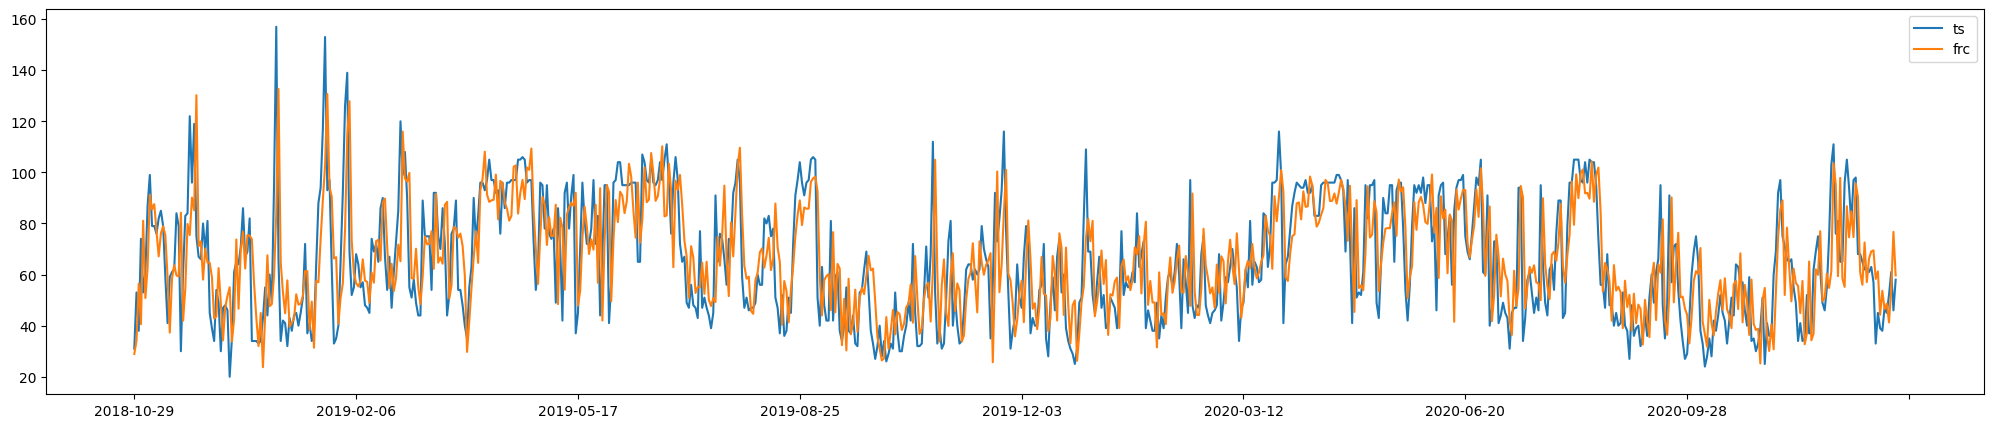

In [8]:
linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)
print('Train score: %.3f, Test score: %.3f'% (linear_regression.score(X_train, y_train), linear_regression.score(X_test, y_test)))
pd.DataFrame({'ts':y_test, 'frc': linear_regression.predict(X_test)}).plot(figsize = (25,5))

Исключи сезонную компоненту

<AxesSubplot: xlabel='Timestamp'>

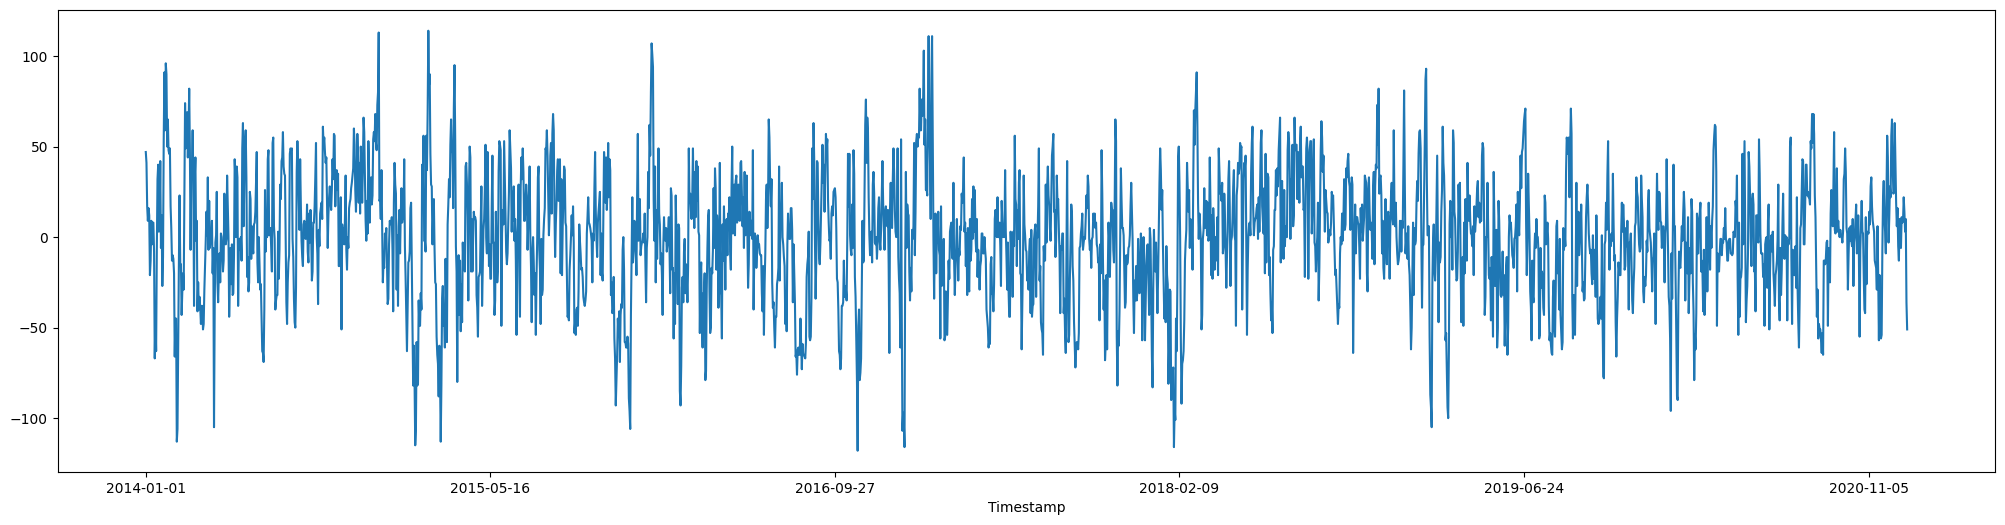

In [9]:
# Lets transform wage ts
# seasonal differencing
s = 365
sdiff_ts_wage = (ts_wage - ts_wage.shift(s))[s:]
sdiff_ts_wage.plot(figsize=(25,6))

# Проверим на стационарность ADF

In [10]:
# Augmented Dickey-Fuller unit root test: 
# H0: ts is not stationary
df_stat = stattools.adfuller(np.array(sdiff_ts_wage))
print('The Augmented Dickey-Fuller test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ncritical values: %s' % 
      (df_stat[0], df_stat[1], df_stat[2], df_stat[4]))

The Augmented Dickey-Fuller test statistic -17.348223, 
pvalue: 0.00 
maximal Lag: 2 
critical values: {'1%': -3.4329129931922178, '5%': -2.862672327302294, '10%': -2.5673727798916928}


# test statistic -17.348223 - временной ряд стационарный


# KPSS

In [11]:
# Kwiatkowski–Phillips–Schmidt–Shin
# H0: ts is stationary
kpss_stat= stattools.kpss(np.array(sdiff_ts_wage))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.166625, 
pvalue: 0.10 
maximal Lag: 24 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\George\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# statistic 0.166625 - врменной ряд стационарный


In [12]:
ts_wage = pd.read_csv(r'C:/Users/George/Desktop/Magistratyra/Project/Concantinate/result.csv', index_col='Unnamed: 0')
ts_wage.index.names=['Timestamp']
# ts = pd.read_csv('./data/TimeSeries_Data10.csv', sep=',', decimal='.')
ts_wage = ts_wage.sort_index() # sort index

In [13]:
from copy import deepcopy
ts_wage_boxcox = deepcopy(ts_wage)
# find optimal lambda 
print('optimal lambda:', stats.boxcox(ts_wage['AQI'])[1])

optimal lambda: 0.08118349282078492


# Оптимальная lambda = 0.0811 - это что то значит

# BOXCOX

<AxesSubplot: xlabel='Timestamp'>

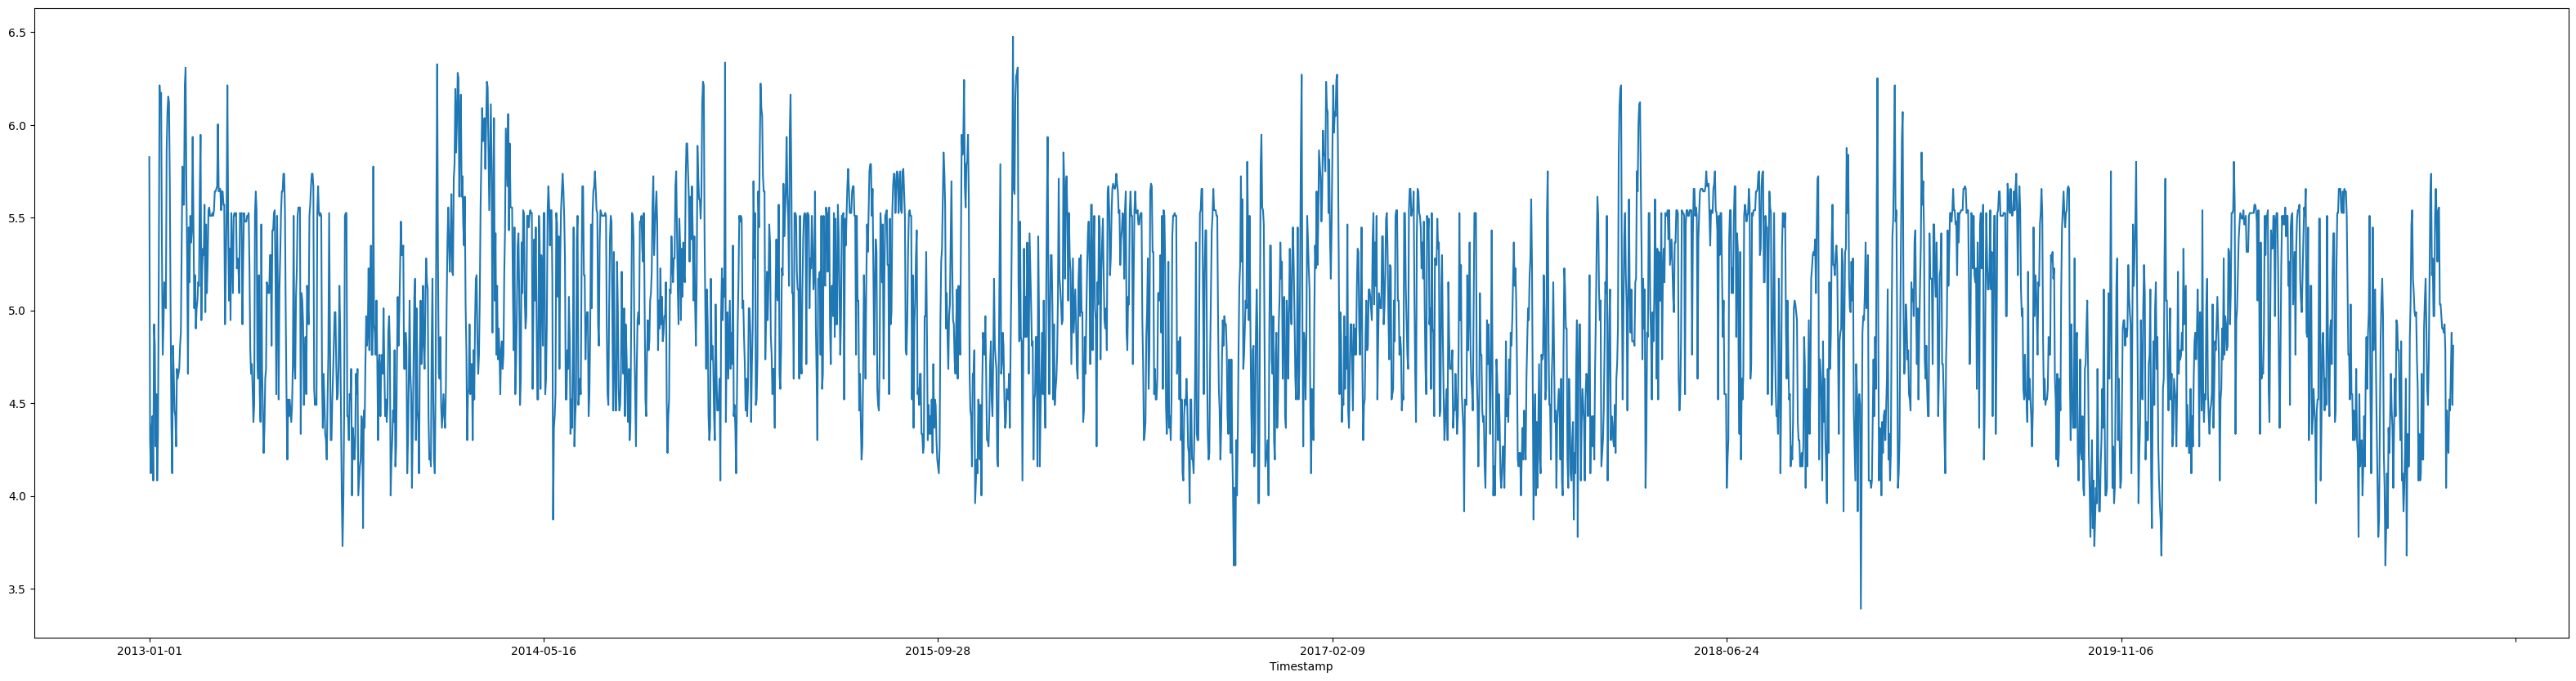

In [14]:
ts_wage_boxcox['wage_boxcox'] = stats.boxcox(ts_wage['AQI'])[0]
ts_wage_boxcox['wage_boxcox'].plot(figsize=(40,10))

<AxesSubplot: xlabel='Timestamp'>

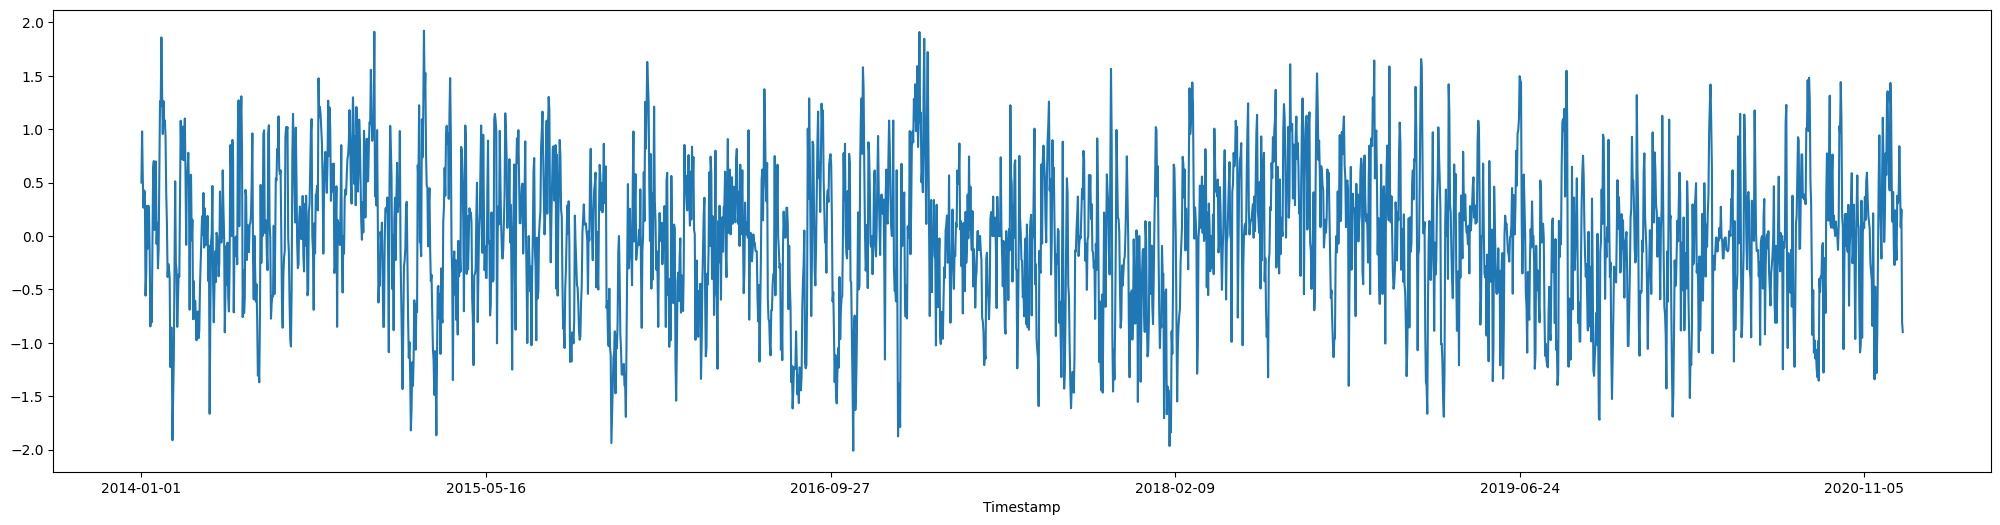

In [15]:
sdiff_ts_wage_boxcox = (ts_wage_boxcox - ts_wage_boxcox.shift(s))[s:]
sdiff_ts_wage_boxcox['wage_boxcox'].plot(figsize=(25,6))

In [16]:
# Augmented Dickey-Fuller unit root test
# H0: ts is not stationary
df_stat = stattools.adfuller(np.array(sdiff_ts_wage_boxcox['wage_boxcox']))
print('The Augmented Dickey-Fuller test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ncritical values: %s' % 
      (df_stat[0], df_stat[1], df_stat[2], df_stat[4]))

The Augmented Dickey-Fuller test statistic -17.754000, 
pvalue: 0.00 
maximal Lag: 2 
critical values: {'1%': -3.4329129931922178, '5%': -2.862672327302294, '10%': -2.5673727798916928}


Временной ряд - стационарен

In [17]:
# Kwiatkowski–Phillips–Schmidt–Shin
# H0: ts is stationary
kpss_stat= stattools.kpss(np.array(sdiff_ts_wage_boxcox['wage_boxcox']))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.187582, 
pvalue: 0.10 
maximal Lag: 24 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\George\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## Временной ряд стационарен.

# Построим ARIMA и SARIMA модели

n: Порядок авторегрессии тренда.<br>
d: Порядок изменения тренда.<br>
q: Тренд скользящей средней.<br>

In [18]:
ts_wage_boxcox = deepcopy(ts_wage)
# find optimal lambda 
print('optimal lambda:', stats.boxcox(ts_wage['AQI'])[1])

# Box_Cox transformation (see lesson 4 for details)
ts_wage_boxcox['wage_boxcox'] = np.log(ts_wage['AQI'])
# ts_wage_boxcox['wage_boxcox'].plot()


# seasonal differencing
p = 365
sdiff_ts_wage_boxcox = (ts_wage_boxcox['wage_boxcox'] - ts_wage_boxcox['wage_boxcox'].shift(p))[p:]
# sdiff_ts_wage_boxcox.plot()


# Kwiatkowski–Phillips–Schmidt–Shin
kpss_stat= stattools.kpss(np.array(sdiff_ts_wage_boxcox))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

# Augmented Dickey-Fuller unit root test
df_stat = stattools.adfuller(np.array(sdiff_ts_wage_boxcox))
print('The Augmented Dickey-Fuller test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ncritical values: %s' % 
      (df_stat[0], df_stat[1], df_stat[2], df_stat[4]))


optimal lambda: 0.08118349282078492
The KPSS test statistic 0.189349, 
pvalue: 0.10 
maximal Lag: 24 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The Augmented Dickey-Fuller test statistic -17.803010, 
pvalue: 0.00 
maximal Lag: 2 
critical values: {'1%': -3.4329129931922178, '5%': -2.862672327302294, '10%': -2.5673727798916928}


C:\Users\George\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [19]:
# Let's train our first ARMA(p,q) model
arma_mod00 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, order =(0, 0, 0)).fit()
print(arma_mod00.summary())

C:\Users\George\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\George\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\George\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            wage_boxcox   No. Observations:                 2557
Model:                          ARIMA   Log Likelihood               -1764.944
Date:                Mon, 19 Dec 2022   AIC                           3533.888
Time:                        23:22:40   BIC                           3545.582
Sample:                    01-01-2014   HQIC                          3538.129
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0097      0.010     -1.010      0.312      -0.028       0.009
sigma2         0.2328      0.007     33.181      0.000       0.219       0.247
Ljung-Box (L1) (Q):                1149.59   Jarque-

Log Likelihood               -1231.626

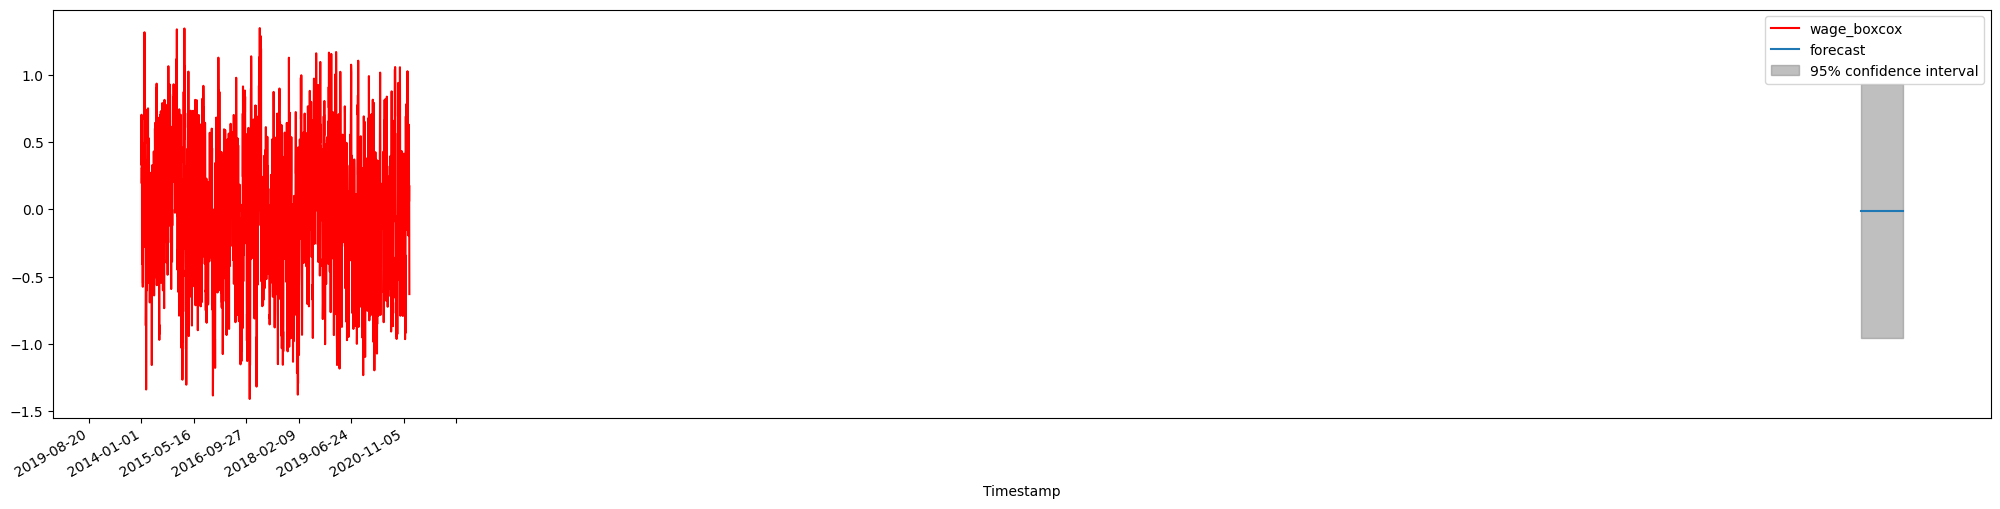

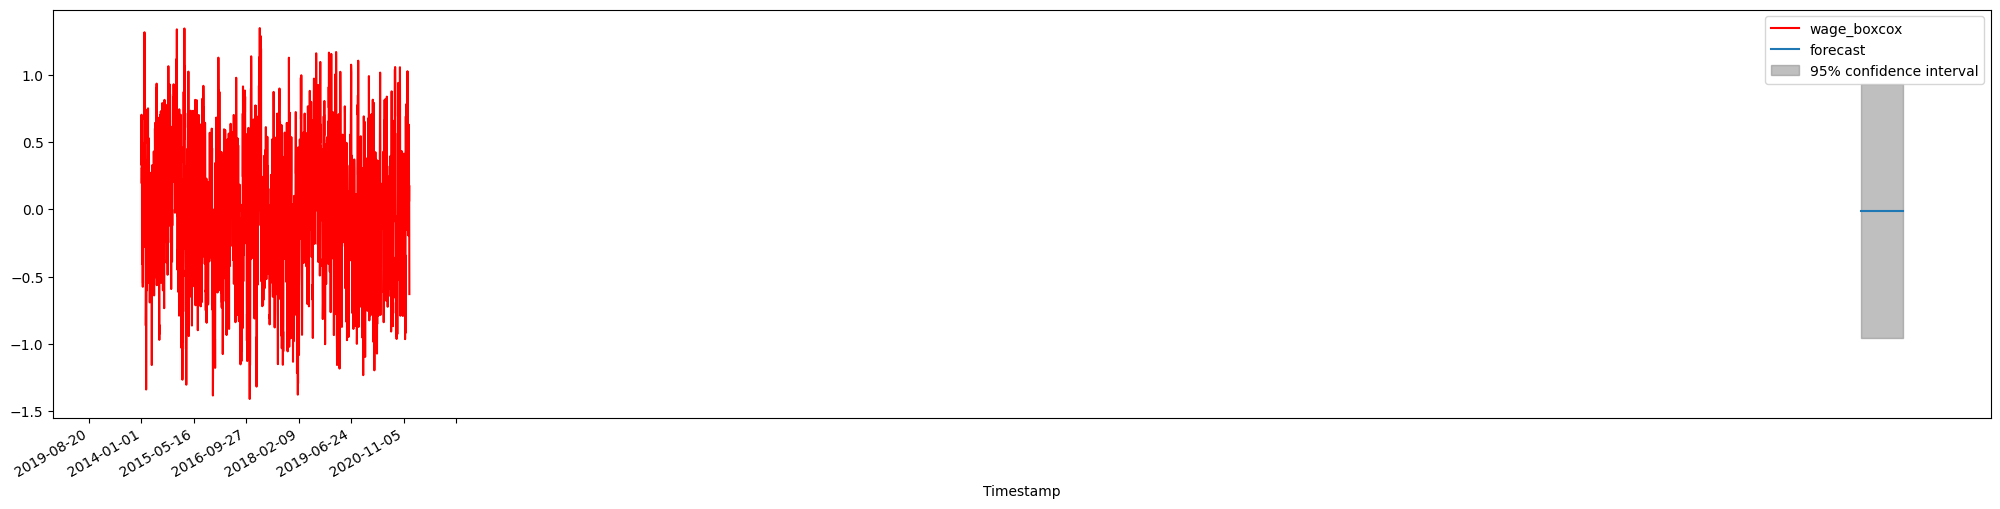

In [20]:
# fig, ax = plt.subplots(figsize=(40,5),  linewidth=3.0)
ax = sdiff_ts_wage_boxcox.plot(figsize=(25,6),color = 'red')
plot_predict(arma_mod00,start='2014-12-01', end='2016-01-01', ax=ax)
#fig = plot_predict(arma_mod00)

# Построим SARIMA модель

n: Порядок авторегрессии тренда.<br>
d: Порядок изменения тренда.<br>
q: Тренд скользящей средней.<br>
P: Сезонный порядок авторегрессии.<br>
D: Порядок сезонных разниц.<br>
Q: Сезонный порядок скользящих средних.<br>
s: Количество временных шагов за один сезонный период.<br>

In [21]:
# Let's train our first ARIMA (p, d, q)x(P, D, Q, s) model
arima_000_010 = sm.tsa.SARIMAX(endog = ts_wage_boxcox['wage_boxcox'], order=(0, 0, 0), seasonal_order = (0,1,0,12)).fit()
print(arima_000_010.summary())


predict = arima_000_010.get_prediction()
predict_ci = predict.conf_int() # confidence interval


start_dt = '2013-01-01'


# # Graph

# #npre = 4
# #ax.set(title='Wage', xlabel='Date')

# # Plot data points
# #ts_wage_boxcox.loc[start_dt:, 'wage_boxcox'].plot(ax=ax, style='o', label='Observed')

# # Plot predictions
# predict.predicted_mean[start_dt:].plot(ax=ax, style='r--', label='One-step-ahead forecast')
# ci = predict_ci.loc[start_dt:]
# ax.fill_between(ci.index, ci.loc[:,ci.columns[0]], ci.loc[:,ci.columns[1]], color='r', alpha=0.1)

# legend = ax.legend(loc='lower right')

                                SARIMAX Results                                 
Dep. Variable:              wage_boxcox   No. Observations:                 2922
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood               -1942.009
Date:                  Mon, 19 Dec 2022   AIC                           3886.019
Time:                          23:22:44   BIC                           3891.995
Sample:                      01-01-2013   HQIC                          3888.172
                           - 12-31-2020                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2224      0.006     37.002      0.000       0.211       0.234
Ljung-Box (L1) (Q):                1209.65   Jarque-Bera (JB):                 2.37
Prob(Q):                       

C:\Users\George\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\George\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


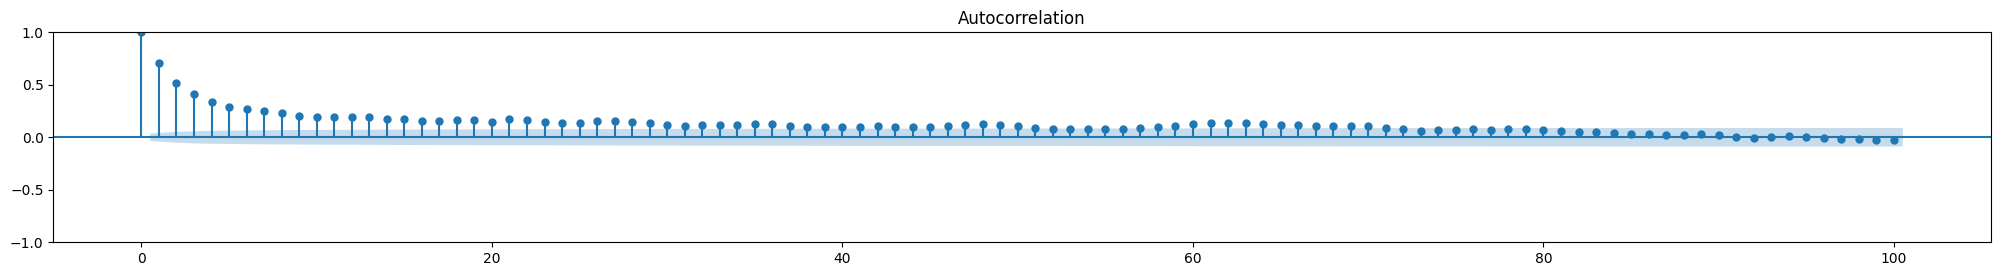

In [22]:
fig = plt.figure(figsize=(25,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_wage_boxcox['wage_boxcox'], lags=100, ax = ax1)

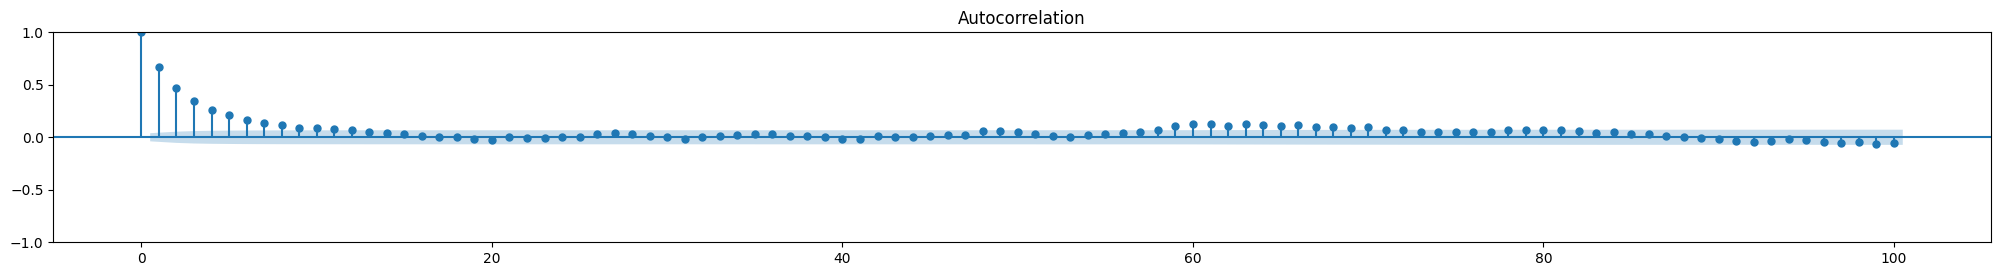

In [23]:
fig = plt.figure(figsize=(25,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sdiff_ts_wage_boxcox, lags=100, ax = ax1)

# Поробуем понять какие параметры подбирать

C:\Users\George\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


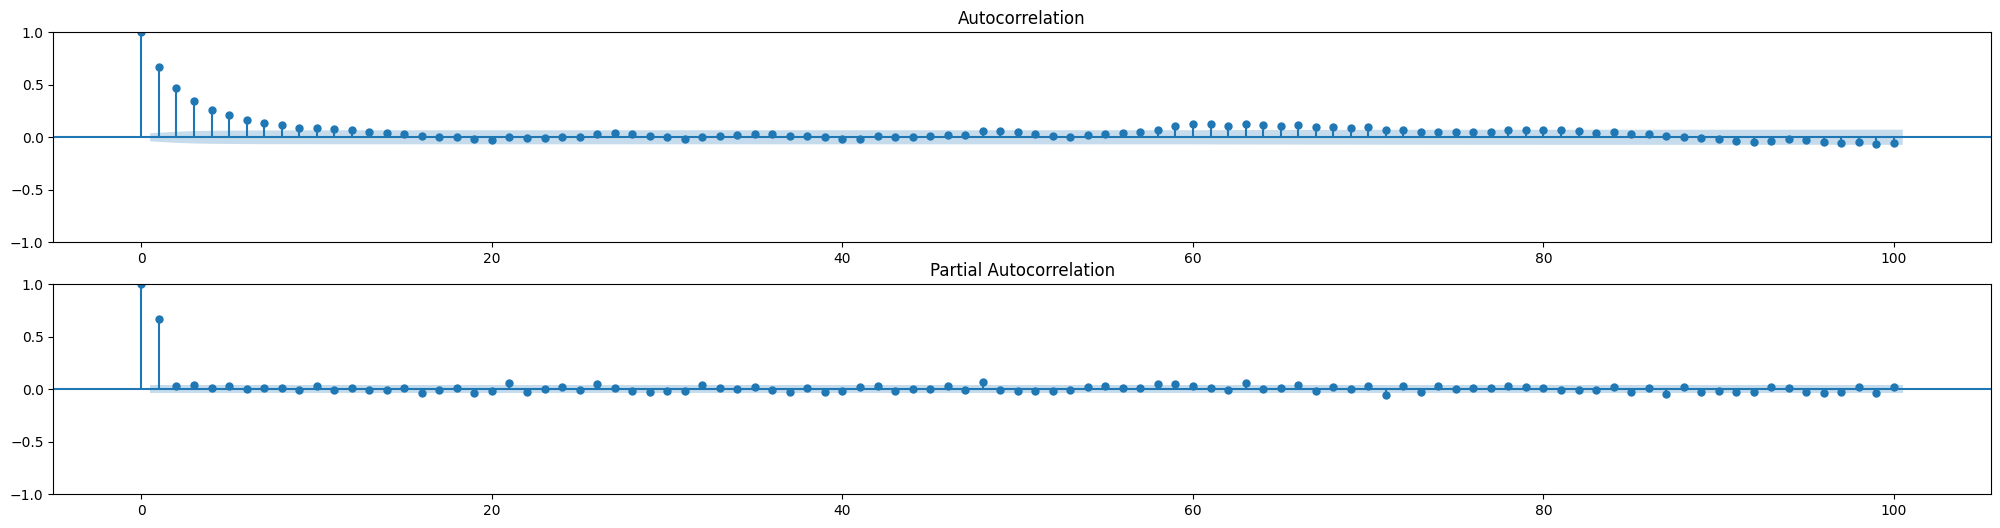

In [24]:
fig = plt.figure(figsize=(25,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sdiff_ts_wage_boxcox, lags=100, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sdiff_ts_wage_boxcox, lags=100, ax=ax2)

In [25]:
# Let's train our first ARIMA (p, d, q)x(P, D, Q, s) model
arima_111_311 = sm.tsa.SARIMAX(endog = ts_wage_boxcox['wage_boxcox'], order=(1, 1, 1), seasonal_order = (3,1,1,12)).fit()
print(arima_111_311.summary())


predict = arima_111_311.get_prediction()
predict_ci = predict.conf_int() # confidence interval


start_dt = '2013-01-01'


# # Graph

# #npre = 4
# #ax.set(title='Wage', xlabel='Date')

# # Plot data points
# #ts_wage_boxcox.loc[start_dt:, 'wage_boxcox'].plot(ax=ax, style='o', label='Observed')

# # Plot predictions
# predict.predicted_mean[start_dt:].plot(ax=ax, style='r--', label='One-step-ahead forecast')
# ci = predict_ci.loc[start_dt:]
# ax.fill_between(ci.index, ci.loc[:,ci.columns[0]], ci.loc[:,ci.columns[1]], color='r', alpha=0.1)

# legend = ax.legend(loc='lower right')

C:\Users\George\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\George\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\George\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                        wage_boxcox   No. Observations:                 2922
Model:             SARIMAX(1, 1, 1)x(3, 1, 1, 12)   Log Likelihood                -228.438
Date:                            Mon, 19 Dec 2022   AIC                            470.875
Time:                                    23:23:24   BIC                            512.704
Sample:                                01-01-2013   HQIC                           485.945
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6451      0.016     41.115      0.000       0.614       0.676
ma.L1         -0.9684      0.006   

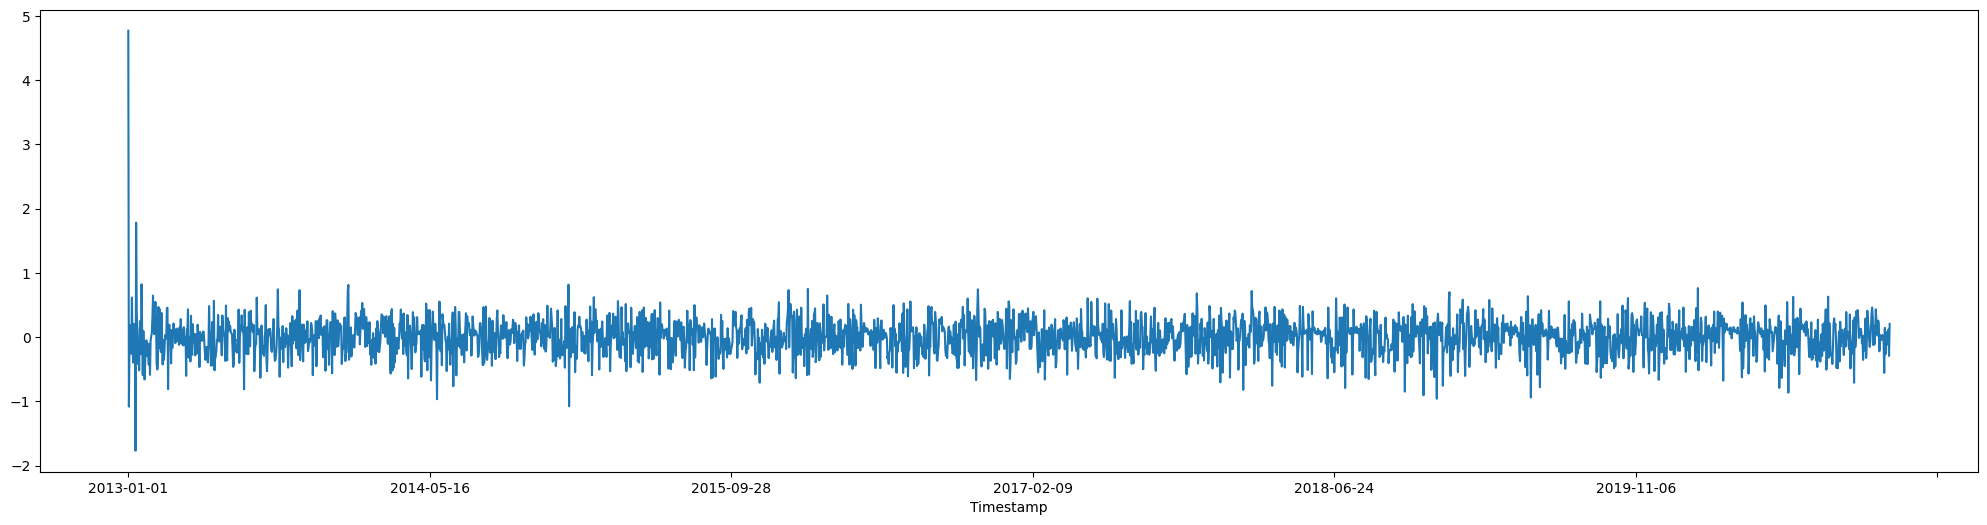

In [26]:
# plot residuals
fig = plt.figure(figsize=(25,6))
ax = fig.add_subplot(111)
ax = arima_111_311.resid.plot(ax=ax);

### Autocorrelation test

C:\Users\George\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


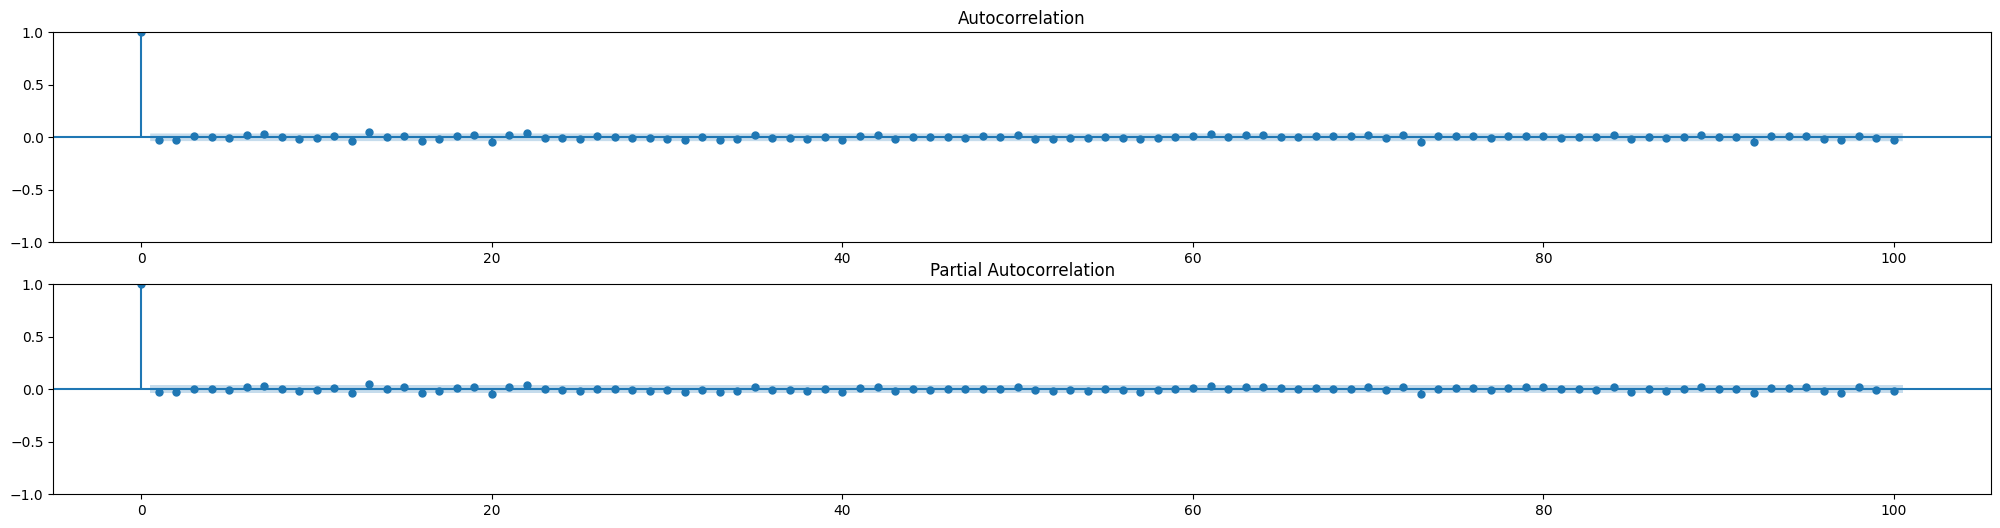

In [27]:
# Autocorrelation analysis of residuals
fig = plt.figure(figsize=(25,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_111_311.resid.values, lags=100, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_111_311.resid.values, lags=100, ax=ax2)

# Тест Юнга-Бокса

In [28]:
# # Ljung-Box test 
# # H0: there is no correlcation for lag
# pd.DataFrame({'lags':range(100), 'pvalue':sm.stats.diagnostic.acorr_ljungbox(arima_111_311.resid.values, lags=100)[100], 
#               'critial':np.array([0.05]*100)}).set_index('lags').plot()
sm.stats.acorr_ljungbox(arima_111_311.resid, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,9.09046,0.523541


lb_pvalue - остатки являются независимыми

# Попробуем подобрать параметры через сетку

In [31]:
#x_train = data['AQI']['2013-01-01':'2018-01-01']
#x_test =  data['AQI']['2018-01-02':'2020-12-31']

In [34]:
from sklearn.metrics import mean_squared_error
p_values = range(0,30)
d_values = range(0, 2)
q_values = range(0, 2)
res = {}

In [44]:
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            warnings.filterwarnings("ignore")
            model = sm.tsa.SARIMAX(x_train, order=order).fit()
            predictions = model.predict(start=len(x_train), end=len(x_train) + len(x_test)-1)
            error = mean_squared_error(x_test, predictions)
            res[order]=error
            print(order,error)

(0, 0, 0) 5193.486757990868
(0, 0, 1) 5192.371720617314
(0, 1, 0) 667.3570776255708
(0, 1, 1) 605.3013235783077
(1, 0, 0) 5019.675578065667
(1, 0, 1) 4875.631108220803
(1, 1, 0) 630.1722310352365
(1, 1, 1) 853.5959413159749
(2, 0, 0) 4956.249917543682
(2, 0, 1) 957.3105909672739
(2, 1, 0) 601.6830202907107
(2, 1, 1) 861.0308076395283
(3, 0, 0) 4852.018439610318
(3, 0, 1) 975.7889360165602
(3, 1, 0) 601.0574644911309
(3, 1, 1) 843.8907327454376
(4, 0, 0) 4724.771003332956
(4, 0, 1) 936.4850756242607
(4, 1, 0) 606.9704474850532
(4, 1, 1) 813.5351236800876
(5, 0, 0) 4608.273215346056
(5, 0, 1) 890.7502515705362
(5, 1, 0) 614.8581227223972
(5, 1, 1) 793.152588409881
(6, 0, 0) 4510.511181508502
(6, 0, 1) 850.0752959185777
(6, 1, 0) 628.6082177006747
(6, 1, 1) 794.9244845805355
(7, 0, 0) 4423.042773000284
(7, 0, 1) 755.2695166579188
(7, 1, 0) 643.346981250237
(7, 1, 1) 801.3607257681667
(8, 0, 0) 4314.066757336126
(8, 0, 1) 1208.9864658305328
(8, 1, 0) 656.1016546878092
(8, 1, 1) 797.4834809

### Минимальное значение MSE

In [45]:
print(min(res.values()))

601.0574644911309


### Параметры соответсвующие минимальному значению MSE

In [48]:
for key,value in res.items():
    if value==601.0574644911309:
        print("key by value:",key)

key by value: (3, 1, 0)


# Проведем оценку на MAE

In [50]:
from sklearn.metrics import mean_absolute_error

In [51]:
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            warnings.filterwarnings("ignore")
            model = sm.tsa.SARIMAX(x_train, order=order).fit()
            predictions = model.predict(start=len(x_train), end=len(x_train) + len(x_test)-1)
            error = mean_absolute_error(x_test, predictions)
            res[order]=error
            print(order,error)

(0, 0, 0) 67.77716894977169
(0, 0, 1) 67.74703972687047
(0, 1, 0) 22.385388127853883
(0, 1, 1) 21.24161620752098
(1, 0, 0) 66.17850466844732
(1, 0, 1) 65.05989670835234
(1, 1, 0) 21.753981835659584
(1, 1, 1) 23.0350864811741
(2, 0, 0) 65.68040113789678
(2, 0, 1) 24.152898214687387
(2, 1, 0) 21.12341657961026
(2, 1, 1) 23.111361023664937
(3, 0, 0) 64.88131020344326
(3, 0, 1) 24.368171251235772
(3, 1, 0) 20.94329901071842
(3, 1, 1) 22.937326620441997
(4, 0, 0) 63.92459017725008
(4, 0, 1) 23.91411818721253
(4, 1, 0) 20.89959759825072
(4, 1, 1) 22.631539613033244
(5, 0, 0) 63.03401327668479
(5, 0, 1) 23.411981459302645
(5, 1, 0) 20.908192127996635
(5, 1, 1) 22.42505310239123
(6, 0, 0) 62.26545092214787
(6, 0, 1) 22.983910120771213
(6, 1, 0) 20.972411027217454
(6, 1, 1) 22.44345289388122
(7, 0, 0) 61.56643365749377
(7, 0, 1) 22.03740854750394
(7, 1, 0) 21.06305006592402
(7, 1, 1) 22.509743509638866
(8, 0, 0) 60.67934596640693
(8, 0, 1) 27.4597024024375
(8, 1, 0) 21.163254571728842
(8, 1, 1)

In [52]:
print(min(res.values()))

20.89959759825072


In [53]:
for key,value in res.items():
    if value==20.89959759825072:
        print("key by value:",key)

key by value: (4, 1, 0)


# Проведем оценку MSE по всем параметрам

In [76]:
p_values = range(0,5)
d_values = range(0, 2)
q_values = range(0, 2)
P_params = [0, 1, 2]
D_params = [0, 1]
Q_params = [0, 1, 2]
m_params = [12,12]
res1 = {}

In [77]:
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_params:
                for D in D_params:
                    for Q in Q_params:
                        for m in m_params:
                            order = (p,d,q)
                            seasonal_order=(P,D,Q,m)
                            warnings.filterwarnings("ignore")
                            model = sm.tsa.SARIMAX(x_train, order=order,seasonal_order=seasonal_order,initialization='approximate_diffuse',enforce_stationarity = False).fit()
                            predictions = model.predict(start=len(x_train), end=len(x_train) + len(x_test)-1)
                            error = mean_squared_error(x_test, predictions)
                            res1[order]=error
                            print(order,seasonal_order,error)

(0, 0, 0) (0, 0, 0, 12) 5193.486757990868
(0, 0, 0) (0, 0, 0, 12) 5193.486757990868
(0, 0, 0) (0, 0, 1, 12) 5169.0248798411
(0, 0, 0) (0, 0, 1, 12) 5169.0248798411
(0, 0, 0) (0, 0, 2, 12) 5154.563678526919
(0, 0, 0) (0, 0, 2, 12) 5154.563678526919
(0, 0, 0) (0, 1, 0, 12) 1107.8438356164384
(0, 0, 0) (0, 1, 0, 12) 1107.8438356164384
(0, 0, 0) (0, 1, 1, 12) 677.5665993987539
(0, 0, 0) (0, 1, 1, 12) 677.5665993987539
(0, 0, 0) (0, 1, 2, 12) 637.8009647955611
(0, 0, 0) (0, 1, 2, 12) 637.8009647955611
(0, 0, 0) (1, 0, 0, 12) 4651.343276982568
(0, 0, 0) (1, 0, 0, 12) 4651.343276982568
(0, 0, 0) (1, 0, 1, 12) 635.455005585849
(0, 0, 0) (1, 0, 1, 12) 635.455005585849
(0, 0, 0) (1, 0, 2, 12) 687.679494278936
(0, 0, 0) (1, 0, 2, 12) 687.679494278936
(0, 0, 0) (1, 1, 0, 12) 1141.7636650040643
(0, 0, 0) (1, 1, 0, 12) 1141.7636650040643
(0, 0, 0) (1, 1, 1, 12) 654.920168768043
(0, 0, 0) (1, 1, 1, 12) 654.920168768043
(0, 0, 0) (1, 1, 2, 12) 666.0701564441373
(0, 0, 0) (1, 1, 2, 12) 666.070156444137

(1, 0, 1) (1, 0, 2, 12) 660.0416747590044
(1, 0, 1) (1, 0, 2, 12) 660.0416747590044
(1, 0, 1) (1, 1, 0, 12) 996.3618394125721
(1, 0, 1) (1, 1, 0, 12) 996.3618394125721
(1, 0, 1) (1, 1, 1, 12) 609.5832383404503
(1, 0, 1) (1, 1, 1, 12) 609.5832383404503
(1, 0, 1) (1, 1, 2, 12) 601.0616953290049
(1, 0, 1) (1, 1, 2, 12) 601.0616953290049
(1, 0, 1) (2, 0, 0, 12) 4849.0251102956445
(1, 0, 1) (2, 0, 0, 12) 4849.0251102956445
(1, 0, 1) (2, 0, 1, 12) 4849.316669719169
(1, 0, 1) (2, 0, 1, 12) 4849.316669719169
(1, 0, 1) (2, 0, 2, 12) 685.2765063838598
(1, 0, 1) (2, 0, 2, 12) 685.2765063838598
(1, 0, 1) (2, 1, 0, 12) 978.1578489191154
(1, 0, 1) (2, 1, 0, 12) 978.1578489191154
(1, 0, 1) (2, 1, 1, 12) 609.8136474496946
(1, 0, 1) (2, 1, 1, 12) 609.8136474496946
(1, 0, 1) (2, 1, 2, 12) 607.3590199081153
(1, 0, 1) (2, 1, 2, 12) 607.3590199081153
(1, 1, 0) (0, 0, 0, 12) 630.690425295993
(1, 1, 0) (0, 0, 0, 12) 630.690425295993
(1, 1, 0) (0, 0, 1, 12) 632.4149312313176
(1, 1, 0) (0, 0, 1, 12) 632.414931

(2, 1, 0) (2, 1, 0, 12) 233154.9994821968
(2, 1, 0) (2, 1, 1, 12) 1033.9296242905953
(2, 1, 0) (2, 1, 1, 12) 1033.9296242905953
(2, 1, 0) (2, 1, 2, 12) 762.19993849448
(2, 1, 0) (2, 1, 2, 12) 762.19993849448
(2, 1, 1) (0, 0, 0, 12) 872.2443663587862
(2, 1, 1) (0, 0, 0, 12) 872.2443663587862
(2, 1, 1) (0, 0, 1, 12) 862.6993198442141
(2, 1, 1) (0, 0, 1, 12) 862.6993198442141
(2, 1, 1) (0, 0, 2, 12) 871.1785513400368
(2, 1, 1) (0, 0, 2, 12) 871.1785513400368
(2, 1, 1) (0, 1, 0, 12) 1048.1644715636594
(2, 1, 1) (0, 1, 0, 12) 1048.1644715636594
(2, 1, 1) (0, 1, 1, 12) 1251.7162466200248
(2, 1, 1) (0, 1, 1, 12) 1251.7162466200248
(2, 1, 1) (0, 1, 2, 12) 1392.8371082806873
(2, 1, 1) (0, 1, 2, 12) 1392.8371082806873
(2, 1, 1) (1, 0, 0, 12) 865.9433028311511
(2, 1, 1) (1, 0, 0, 12) 865.9433028311511
(2, 1, 1) (1, 0, 1, 12) 856.996839604008
(2, 1, 1) (1, 0, 1, 12) 856.996839604008
(2, 1, 1) (1, 0, 2, 12) 871.1910801458064
(2, 1, 1) (1, 0, 2, 12) 871.1910801458064
(2, 1, 1) (1, 1, 0, 12) 1360.005

(4, 0, 0) (0, 1, 2, 12) 600.7021632738542
(4, 0, 0) (0, 1, 2, 12) 600.7021632738542
(4, 0, 0) (1, 0, 0, 12) 4763.494278372757
(4, 0, 0) (1, 0, 0, 12) 4763.494278372757
(4, 0, 0) (1, 0, 1, 12) 4756.743636126612
(4, 0, 0) (1, 0, 1, 12) 4756.743636126612
(4, 0, 0) (1, 0, 2, 12) 680.0394264344086
(4, 0, 0) (1, 0, 2, 12) 680.0394264344086
(4, 0, 0) (1, 1, 0, 12) 971.9180525845974
(4, 0, 0) (1, 1, 0, 12) 971.9180525845974
(4, 0, 0) (1, 1, 1, 12) 609.1986424105835
(4, 0, 0) (1, 1, 1, 12) 609.1986424105835
(4, 0, 0) (1, 1, 2, 12) 605.8764903142963
(4, 0, 0) (1, 1, 2, 12) 605.8764903142963
(4, 0, 0) (2, 0, 0, 12) 4691.38493225468
(4, 0, 0) (2, 0, 0, 12) 4691.38493225468
(4, 0, 0) (2, 0, 1, 12) 4685.375025283768
(4, 0, 0) (2, 0, 1, 12) 4685.375025283768
(4, 0, 0) (2, 0, 2, 12) 698.3106945038116
(4, 0, 0) (2, 0, 2, 12) 698.3106945038116
(4, 0, 0) (2, 1, 0, 12) 962.9430919366829
(4, 0, 0) (2, 1, 0, 12) 962.9430919366829
(4, 0, 0) (2, 1, 1, 12) 608.1803305841328
(4, 0, 0) (2, 1, 1, 12) 608.18033058

In [79]:
print(min(res1.values()))

600.8096118257603


In [83]:
for key,value in res1.items():
    if value==600.8096118257603:
        print("key by value:",key)

key by value: (1, 0, 0)


# Оптимальные параметры


(1, 0, 0) (2, 1, 2, 12) 600.8096118257603 <br>
(1, 0, 0) (2, 1, 2, 12) 600.8096118257603 <br>